In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from MotionBERT.common_import import *

In [2]:
### verify laod data
data_type_list = [
    'source_list', 'cam_param',
    'cam_3d', 'img_2d',
    'cam_3d_canonical_revolute', 'img_2d_canonical_revolute',
    'img_3d', 'scale_factor', # from LCN
    # 'img_3d_canonical_revolute', 'scale_factor_canonical_revolute', # from LCN
    # 'img_3d_norm', 'scale_factor_norm', # from ours
    # 'img_3d_norm_canonical_revolute', 'scale_factor_norm_canonical_revolute', # from ours
]
overwrite_list = []
dataset_name = 'h36m'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug)

[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...


[overwrite: False] ==> Loading H36M img_2d...
[overwrite: False] ==> Loading H36M cam_3d_canonical_revolute...
[overwrite: False] ==> Loading H36M img_2d_canonical_revolute...
[overwrite: False] ==> Loading H36M img_3d...
[overwrite: False] ==> Loading H36M scale_factor...


In [11]:
source_list = data['source_list'].copy()
source = source_list[0]
subject, cam_id, action = split_source_name(source, dataset_name)
cam_param = data['cam_param'][subject][action][cam_id].copy()
intrinsic = cam_param['intrinsic']
W, H = cam_param['W'], cam_param['H']
cam_3d = data['cam_3d'][subject][action][cam_id].copy()
img_2d = data['img_2d'][subject][action][cam_id].copy()
img_2d_norm = normalize_input(img_2d, W, H)
img_2d_norm_centered = img_2d_norm.copy() - img_2d_norm[:, 0:1]
img_3d_loaded = data['img_3d'][subject][action][cam_id].copy()
scale_factor_loaded = data['scale_factor'][subject][action][cam_id].copy()
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
cam_3d_canonical = data['cam_3d_canonical_revolute'][subject][action][cam_id].copy()
img_2d_canonical = data['img_2d_canonical_revolute'][subject][action][cam_id].copy()
img_2d_canonical_norm = normalize_input(img_2d_canonical, W, H)
img_2d_canonical_norm_centered = img_2d_canonical_norm.copy() - img_2d_canonical_norm[:, 0:1]

### 동일한 값을 계산하는가?

In [7]:
# LCN img_3d
cam_3d = data['cam_3d'][subject][action][cam_id].copy() * 1000
root_joint = cam_3d[:, 0] # (N, 3)
tl_joint = root_joint.copy() # top left point of the bounding box
br_joint = root_joint.copy() # bottom right point of the bounding box
tl_joint[:, :2] -= 1000.0
br_joint[:, :2] += 1000.0
tl_2d = tl_joint @ intrinsic.T # projected top left point
tl_2d = tl_2d / tl_2d[:, 2:]
br_2d = br_joint @ intrinsic.T # projected bottom right point
br_2d = br_2d / br_2d[:, 2:]
box = np.stack([tl_2d[:, 0], tl_2d[:, 1], br_2d[:, 0], br_2d[:, 1]], axis=1) # (N, 4) - top left x, top left y, bottom right x, bottom right y
ratio = (box[:, 2] - box[:, 0] + 1) / 2000.0 # (N,)
img_3d_depth = ratio.reshape(-1, 1)*(cam_3d[...,2] - cam_3d[:,0:1,2]) # (N, 17, 1)
# img_3d
img_3d = np.zeros_like(cam_3d)
img_3d[...,:2] = img_2d.copy()
img_3d[...,2] = img_3d_depth.copy()
img_3d_norm = normalize_input(img_3d, W, H)
img_3d_norm_hat = img_3d_norm.copy() - img_3d_norm[:,0:1,:]

In [8]:
box

array([[266.52877838, 222.59419798, 677.69874546, 633.30873448],
       [266.22724258, 222.63944855, 677.43866602, 633.39539549],
       [266.03172349, 222.7559873 , 677.34676927, 633.61544181],
       ...,
       [270.1772677 , 234.91695662, 693.26635362, 657.5374098 ],
       [269.67729235, 234.91111436, 692.82201143, 657.58713908],
       [269.18755991, 234.99411429, 692.38692818, 657.72472767]])

In [9]:
cam_3d_xy = cam_3d.copy()[..., :2]
scale_cam_3d =  get_euclidean_norm_from_pose(cam_3d_xy)
scale_img_2d = get_euclidean_norm_from_pose(img_2d)
scale_img_2d / scale_cam_3d 

array([0.95848783, 0.95948447, 0.96065992, ..., 1.3353478 , 1.33850897,
       1.34135532])

In [10]:
ratio

array([0.20608498, 0.20610571, 0.20615752, ..., 0.21204454, 0.21207236,
       0.21209968])

In [21]:
# LCN scale_factor
cam_3d_hat = cam_3d - cam_3d[:, 0:1, :]
img_3d_hat = img_3d - img_3d[:, 0:1, :]

frame_num = 0
pred_lambda, losses = optimize_scaling_factor(img_3d_hat[frame_num], cam_3d_hat[frame_num])
pred_lambda

0.004817809909582138

In [12]:
# My img_3d and scale_factor
cam_3d = data['cam_3d'][subject][action][cam_id].copy()
my_img_3d, my_scale_factor = generate_img_3d(cam_3d, img_2d_norm)
my_img_3d_hat = my_img_3d - my_img_3d[:, 0:1, :]

In [13]:
my_scale_factor

array([0.41450978, 0.41455972, 0.41461714, ..., 0.40779452, 0.40787161,
       0.40792629])

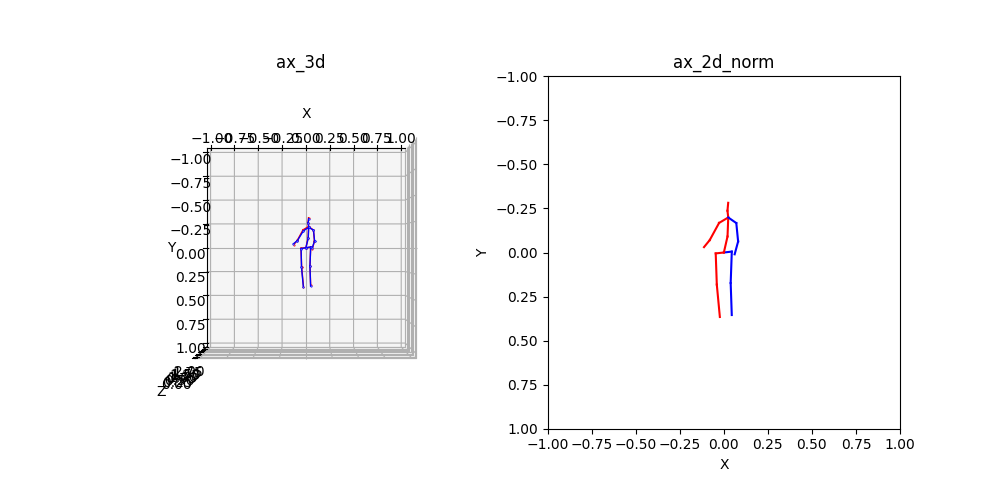

In [14]:
%matplotlib widget
# check original train data
frame_num = 0
configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam', 'xlim': [-1, 1], 'ylim': [-1, 1], 'zlim': [0, 2]},
    #'ax_2d': {'type': '2d', 'loc': 122, 'W': W, 'H': H},
    'ax_2d_norm': {'type': '2d', 'loc': 122, 'normalize': True},
}

fig, axs = generate_axes(0, configs, figsize=[10, 5], fig_title='')
plot_pose_setting = [
    ('ax_3d', img_3d_norm_hat, {'color': 'r', 'label': ''}),
    ('ax_3d', my_img_3d_hat, {'color': 'b', 'label': ''}),
    ('ax_2d_norm', img_2d_norm_centered, {'color': '', 'label': ''}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

### Canonical 유무 차이는? => 2D pose가 달라지므로 약간의 residual은 발생

In [4]:
# My img_3d and scale_factor
my_img_3d_canonical, my_scale_factor_canonical = generate_img_3d(cam_3d_canonical, img_2d_canonical_norm_centered)

In [6]:
# My img_3d and scale_factor
cam_3d = data['cam_3d'][subject][action][cam_id].copy()
my_img_3d, my_scale_factor = generate_img_3d(cam_3d, img_2d_norm)

In [20]:
my_scale_factor_canonical - my_scale_factor

array([-0.00494107, -0.00498974, -0.00501585, ..., -0.00285774,
       -0.00298175, -0.00307814])

### Optimization vs Direct scale calculation

In [9]:
# My img_3d and scale_factor
cam_3d = data['cam_3d'][subject][action][cam_id].copy()
my_img_3d, my_scale_factor = generate_img_3d(cam_3d, img_2d_norm_centered)
my_scale_factor[0]

0.4145097751459471

In [19]:
img_2d_norm_centered[frame_num].shape, cam_3d_hat[frame_num, :, :2].shape

((17, 2), (17, 2))

In [21]:
# optimization
frame_num = 0
pred_lambda, losses = optimize_scaling_factor(cam_3d_hat[frame_num, :, :2], img_2d_norm_centered[frame_num], epochs=500)

In [25]:
scaled_pose3d = cam_3d_hat[frame_num] * -pred_lambda

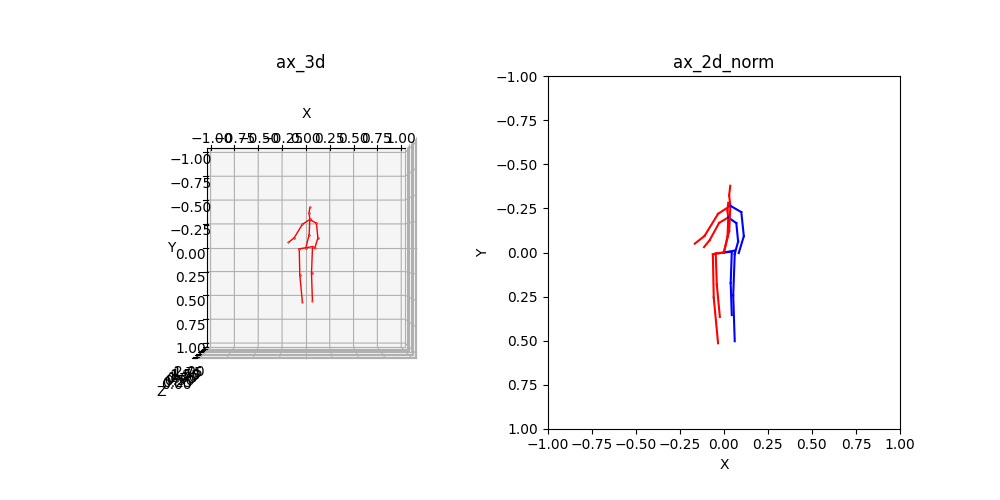

In [27]:
%matplotlib widget
# check original train data
frame_num = 0
configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam', 'xlim': [-1, 1], 'ylim': [-1, 1], 'zlim': [0, 2]},
    #'ax_2d': {'type': '2d', 'loc': 122, 'W': W, 'H': H},
    'ax_2d_norm': {'type': '2d', 'loc': 122, 'normalize': True},
}

fig, axs = generate_axes(0, configs, figsize=[10, 5], fig_title='')
plot_pose_setting = [
    ('ax_3d', scaled_pose3d, {'color': 'r', 'label': ''}),
    ('ax_2d_norm', img_2d_norm_centered, {'color': '', 'label': ''}),
    ('ax_2d_norm', scaled_pose3d, {'color': '', 'label': ''}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()